# Project Physics

In this text we will look, numerically, at the stability of a ship. For a ship to be able to sail across the ocean, it needs to have a certain amount of stability. This stability prevents it from capsizing from the forces that are bound to be affecting the ship on its tour. We will look at how different initial conditions, as well as other factors, such as waves, affects the stability of a ship.

To make the calculations accessible, we need to make simplifications of the ship. Firstly, we will make the problem 2-dimensional by only looking at a slice in the middle of the ship. This simplification does not affect the final result considerably, as it is safe to assume that the forces are close to constant throughout the ship, and our interest is in whether the ship will capsize.

In [128]:
import numpy as np
import matplotlib.pyplot as plt

First of, we need to define our ship. Our ship will be a half-circle with uniform mass (see figure 1**). We need several constants that we will use in the calculations:

In [129]:
R = 10 # Radius of the ship
H = 4 * R / (3 * np.pi) # The distance from the midpoint of the diameter to the center of mass
g = 9.81 # The gravitational acceleration
sigma0 = 1000 # The density of the water
sigma = 500 # The density of the ship

To do some calculations, we first need to identify the forces that act on the ship. We will start by assuming the center of mass stays in place, and the only movement will be a rotation of the ship. As a start, the forces analyzed will be restricted to the updraft of the water. This updraft will, by symmetry, be normal to the surface of the water. With the use of geometry one can find that the area subdued underwater is
$$A = \frac{1}{2}R^2(\gamma-\sin(\gamma))$$
Furthermore, we define the angle $\theta$ as the angle of rotation around the center of mass of the boat. This angle is defined positive counter-clockwise. With further geometry, it can be shown that the angle $\gamma$ can be expressed by $\theta$:
$$\gamma=2 \arccos{\left(\cos(\beta/2)-\frac{4}{3\pi}(1-\cos(\theta)\right)$$
where $\beta$ is the initial $\gamma$ when the ship is in equilibrium.

Now, the total updraft from the water is
$$F_B=A\sigma_0g$$
As a rotation of the ship will displace the center of mass from the center of the updraft force. This gives a torque that can be expressed as:
$$\tau_B = -F_Bh\sin(\theta)$$
It can also be shown that the moment of inertia of the ship around the center of mass is:
$$I_C = \frac{1}{2}mR^2-mH^2$$
Where H is the distance from the midpoint M (see figure 1) to the center of mass C.

In our first simulation, we will neglect the motion of the center of mass of the ship. We therefore assume that the forces on the ship is in equilibrium. The only vertical forces are gravity and bouyancy, and in order to cancel eachother out the area of the ship underwater must be constant. This can be calculated to be:
$$A_0 = \frac{1}{2}R^2 \pi \frac{\sigma}{\sigma_0}$$

We will now use Eulers method to simulate numerically the movement of the ship:

In [130]:
A0 = 1 / 2 * R ** 2 * np.pi * sigma / sigma0 # Area subdued underwater at equilibrium
m = A0 * sigma0 # Mass of the water that is displaced
I_M = 1 / 2 * m * R ** 2 # Moment of inertia of the midpoint M
I_C = I_M - m * H ** 2 # Moment of inertia of the center of mass
omega_0 = (m * g * H / I_C) ** 0.5 # ??

F_G = -m * g # Gravity

def F_B(A): # The updraft force
    return A * sigma0 * g

def tau_B(theta, A): #The torque from the updraft
    return -F_B(A) * H * np.sin(theta)

In [155]:
#Oppgave 1c)

def f(t, w):  # Function that defines the derivative of theta and w
    theta, omega = w
    tau = tau_B(theta, A0)
    return np.array([omega, tau / I_C])

In [132]:
def euler(f, x, y, h):
    y_next = y + h * f(x, y)
    x_next = x + h
    return x_next, y_next

In [133]:
def solve_ode(f, x0, xend, y0, h, method=euler):
    # Initializing:
    y_num = np.array([y0])  # Array for the solution y
    x_num = np.array([x0])  # Array for the x-values

    xn = x0  # Running values for x and y
    yn = y0

    # Main loop
    while xn < xend - 1.e-10:  # Buffer for truncation errors
        xn, yn = method(f, xn, yn, h)  # Do one step by the method of choice

        # Extend the arrays for x and y
        y_num = np.concatenate((y_num, np.array([yn])))
        x_num = np.append(x_num, xn)

    return x_num, y_num

By plotting the angle and the angular velocity of the ship, we should expect similar results to simulations of a pendulum. In this simulation we set the initial angle to be $20^\circ$.

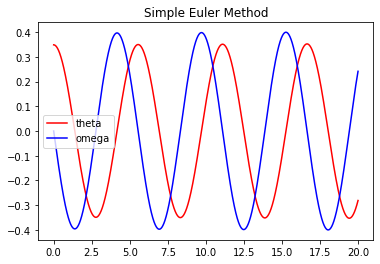

In [134]:
#Oppgave 1d)

t0 = 0
tend = 20
w0 = np.array([20 / 180 * np.pi, 0])
h = 0.001
t_num, w_num = solve_ode(f, t0, tend, w0, h, method=euler)
plt.title("Simple Euler Method")
plt.plot(t_num, w_num[:, 0], 'r')
plt.plot(t_num, w_num[:, 1], 'b')
plt.legend(['theta', 'omega'])
plt.show()

In the definition of the bouyancy $F_B$ the term $\sin(\theta)$ appears. For small values of $\theta$ we can use the approximation $\sin(\theta) = \theta$. To illustrate how accurate this approximation is, we shall compare the solution with approximation $F_B$ together with the correct $F_B$.

In [135]:
#Oppgave 1e)
def tau_B_approx(theta, A):
        return -F_B(A) * H * theta

def f_approx(t, w):  # Function that defines the derivative of theta and w
    theta, omega = w
    tau = tau_B_approx(theta, A0)
    return np.array([omega, tau / I_C])

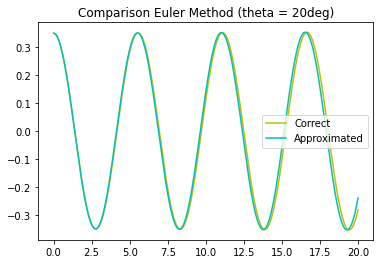

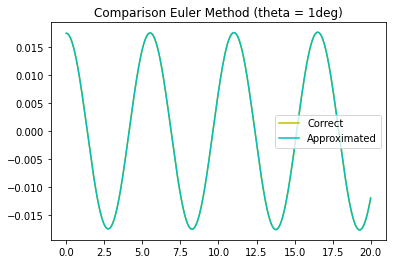

In [136]:
w0 = np.array([20 / 180 * np.pi, 0])
t_num, w_num = solve_ode(f, t0, tend, w0, h, method=euler)
t_num_approx, w_num_approx = solve_ode(f_approx, t0, tend, w0, h, method=euler)
plt.title("Comparison Euler Method (theta = 20deg)")
plt.plot(t_num, w_num[:, 0], 'y')
plt.plot(t_num_approx, w_num_approx[:, 0], 'c')
plt.legend(['Correct', 'Approximated'])
plt.show()

w0 = np.array([1 / 180 * np.pi, 0])
t_num, w_num = solve_ode(f, t0, tend, w0, h, method=euler)
t_num_approx, w_num_approx = solve_ode(f_approx, t0, tend, w0, h, method=euler)
plt.title("Comparison Euler Method (theta = 1deg)")
plt.plot(t_num, w_num[:, 0], 'y')
plt.plot(t_num_approx, w_num_approx[:, 0], 'c')
plt.legend(['Correct', 'Approximated'])
plt.show()

As expected, the approximated plot overlaps much better when the angle is small, however both angles give very precise results when the time passed is short.

A method that is considered to be much better than the Euler method is the Runge Kutta 4 method. We shall now implement this method.

In [137]:
#Oppgave 1f)

def runge_kutta_4(f, x, y, h):
    k1 = f(x, y)
    k2 = f(x + h / 2, y + h / 2 * k1)
    k3 = f(x + h / 2, y + h / 2 * k2)
    k4 = f(x + h, y + h * k3)

    y_next = y + h / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    x_next = x + h
    return x_next, y_next

When we made the approximation for $F_B$, then the differential equation for the system has an exact analytical solution. This is given by
$$\theta(t) = \theta_0 \cdot \cos(F_B H t/I_C)$$

Neither the Euler method nor the RK4 method are exact, however they give better results when the time steps are small. Using both methods, we can plot the difference from the exact solution for different timesteps.

In [138]:
#Oppgave 1g)

def analytic_solution(F_B, h, I, theta0):
    omega0 = np.sqrt(F_B * h / I)

    def theta(t):
        return theta0 * np.cos(omega0 * t)

    return theta

def compare_methods(t, f, t0, w0, h_array):
    w_analytic = analytic_solution(F_B(A0), H, I_C, w0)(t)

    euler_diff_array = np.array([calc_difference_at_t(t, euler, f, t0, w0, h, w_analytic) for h in h_array])
    rk4_diff_array = np.array([calc_difference_at_t(t, runge_kutta_4, f, t0, w0, h, w_analytic) for h in h_array])

    return euler_diff_array, rk4_diff_array


def calc_difference_at_t(t, method, f, t0, theta0, h, w_analytic):
    _, y = solve_ode(f, t0, t, theta0, h, method=method)
    return np.linalg.norm(y[-1] - w_analytic)

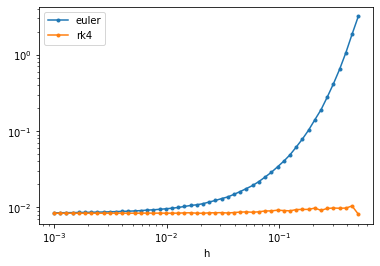

In [157]:
#Oppgave 1h)

def plot_difference(ax, h, difference, **plot_args):
    ax.plot(h, difference, marker=".", **plot_args)


def plot_differences(h, euler, rk4):
    _, ax = plt.subplots(1)
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel("h")

    plot_difference(ax, h, euler, label="euler")
    plot_difference(ax, h, rk4, label="rk4")

    ax.legend()
    plt.show()

h_array = np.exp(np.linspace(*np.log([0.001, 0.5])))  # Evenly spaced on a log-scaled x-axis
w0 = np.array([0.01, 0])
euler_diff_array, rk4_diff_array = compare_methods(t=20, f=f_approx, t0=0, w0=w0, h_array=h_array)
plot_differences(h_array, euler_diff_array, rk4_diff_array)

Text about the accuracy differences of Euler and RK4.....

In [140]:
from scipy.optimize import newton as newtons_method

def sector_angle_eq(sigma, sigma0):
    return lambda beta: beta - np.sin(beta) - np.pi * sigma / sigma0

def sector_angle_eq_derivative(beta):
    return 1 - np.cos(beta)

def calc_sector_angle(sigma, sigma0, R, m_L=0):
    return newtons_method(func=sector_angle_eq(sigma + 2 * m_L / (np.pi * R ** 2), sigma0), x0=2,
                          fprime=sector_angle_eq_derivative)

In [141]:
from functools import cache

def calc_beta(m_L):
    return calc_sector_angle(sigma, sigma0, R, m_L)

beta0 = calc_beta(0)

def y_M0(beta=beta0):
    return R * np.cos(beta / 2)

# Called many times with the same argument
@cache
def y_C0(beta=beta0):
    return y_M0(beta) - H


def y_MB0(beta=beta0):
    return 4 * R * np.sin(beta / 2) ** 3 / (3 * (beta - np.sin(beta)))


def y_B0(beta=beta0):
    return y_M0(beta) - y_MB0(beta)


def y_D0(beta=beta0):
    return y_M0(beta) - R

def calc_gamma(theta, y_C, beta=beta0):
    A = np.cos(beta / 2)
    B = (4 / (3 * np.pi))

    return max(0, 2 * np.arccos(A - B * (1 - np.cos(theta)) + (y_C - y_C0(beta)) / R))

In [159]:
def A(theta, y_C, beta=beta0):
    gamma = calc_gamma(theta, y_C, beta)
    return 0.5 * R ** 2 * (gamma - np.sin(gamma))

#Oppgave 2a)

def f(t, w):
    x_C, y_C, vx, vy, theta, omega = w
    area = A(theta, y_C)
    ay = (F_G + F_B(area)) / m
    ax = 0
    alpha = tau_B(theta, area) / I_C
    return np.array([vx, vy, ax, ay, omega, alpha])

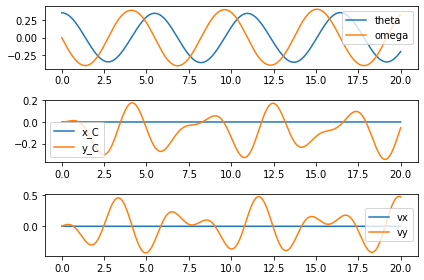

In [143]:
#Oppgave 2b)

def plot_theta(ax, t, theta, **plot_args):
    ax.plot(t, theta, **plot_args)


def plot_omega(ax, t, omega, **plot_args):
    ax.plot(t, omega, **plot_args)


def plot_center_of_gravity(ax, t, x, y):
    ax.plot(t, x, label="x_C")
    ax.plot(t, y, label="y_C")


def plot_vel(ax, t, vx, vy):
    ax.plot(t, vx, label="vx")
    ax.plot(t, vy, label="vy")


def plot_states(t, w):
    x, y, vx, vy, theta, omega = w.T
    _, (ax1, ax2, ax3) = plt.subplots(3)

    plot_theta(ax1, t, theta, label="theta")
    plot_omega(ax1, t, omega, label="omega")
    plot_center_of_gravity(ax2, t, x, y)
    plot_vel(ax3, t, vx, vy)

    for ax in (ax1, ax2, ax3):
        ax.legend()

    plt.tight_layout()
    plt.show()

t0 = 0
tend = 20
w0 = np.array([0, 0, 0, 0, 20 / 180 * np.pi, 0])
h = 0.001
t, w = solve_ode(f, t0, tend, w0, h, method=euler)
plot_states(t, w)

In [144]:
#Oppgave 2c)
def has_capsized(w):
    _, y_C, _, _, theta, _ = w
    return abs(theta) > (np.pi - calc_gamma(theta, y_C)) / 2


def solve_and_set_capsized(t0, tend, w0, h):
    t, w = solve_ode(f, x0=t0, xend=tend, y0=w0, h=h, method=runge_kutta_4)
    theta = w.T[4]

    capsize_index = np.argmax(has_capsized(w.T))
    if capsize_index:  # i.e if not 0; argmax returns 0 if all results are False
        w[capsize_index:] = [0, 0, 0, 0, np.sign(theta[capsize_index]) * np.pi/2, 0]

    return t, w

In [160]:
def find_minimum_capsizing_omega0():
    t0 = x_C0 = vx0 = vy0 = theta0 = 0
    tend = 20
    omega0_array = np.linspace(0.4, 0.5, 30)

    results = (solve_ode(f, x0=t0, xend=tend, y0=np.array([x_C0, y_C0(), vx0, vy0, theta0, omega0]), h=0.01, method=runge_kutta_4)
               for omega0 in omega0_array)
    capsizing_omega0 = (omega0 for omega0 in omega0_array
                        if has_capsized(next(results)[1].T).any())

    min_capsizing_omega0 = next(capsizing_omega0)
    return min_capsizing_omega0

find_minimum_capsizing_omega0()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [146]:
def F_Lx(theta, m_L):
    return m_L * g * np.cos(theta) * np.sin(theta)


def F_Ly(theta, m_L):
    return -m_L * g * np.cos(theta) ** 2


def tau_L(m_L, s_L):
    return m_L * g * s_L

In [147]:
#Oppgave 2d)
def unsecured_cargo_f(m_L):
    def f(t, w):
        x_C, y_C, v_xC, v_yC, theta, omega, s_L, v_L = w
        area = A(theta, y_C)
        a_yC = (F_G + F_B(area)) / m
        a_xC = 0
        if np.abs(s_L) < R:
            a_L = -np.sin(theta) * g
            a_yC -= a_L * m_L / m
            alpha = (tau_B(theta, area) + tau_L(m_L, s_L)) / I_C
            return np.array([v_xC, v_yC, a_xC, a_yC, omega, alpha, v_L, a_L])
        else:
            alpha = tau_B(theta, area) / I_C
            return np.array([v_xC, v_yC, a_xC, a_yC, omega, alpha, v_L, 0])

    return f

def plot_cargo(t, x_C, y_C, v_xC, v_yC, theta, omega, s_L, v_L):
    # _, (ax1, ax2, ax3, ax4) = plt.subplots(4)

    plot_states(t, x_C, y_C, v_xC, v_yC, theta, omega)
    _, ax = plt.subplots(1)
    ax.plot(t, s_L, label="s_L")
    ax.plot(t, v_L, label="v_L")
    ax.legend()
    plt.show()

def unsecured_cargo(m_L):
    t0 = x_C0 = vx0 = vy0 = omega0 = s_L0 = v_L0 = 0
    theta0 = 20 / 180 * np.pi
    tend = 20

    beta = calc_beta(m_L)
    w0 = np.array([x_C0, y_C0(beta), vx0, vy0, theta0, omega0, s_L0, v_L0])

    t, w = solve_ode(f=unsecured_cargo_f(m_L), x0=t0, xend=tend, y0=w0, h=0.01, method=runge_kutta_4)

    plot_cargo(t, *w.T)

In [148]:
#Oppgave 2e)
def secured_cargo_f(m_L, dt):
    def f(t, w):
        x_C, y_C, v_xC, v_yC, theta, omega, s_L, v_L = w
        area = A(theta, y_C)
        a_yC = (F_G + F_B(area)) / m
        a_xC = 0
        a_L = -np.sin(theta) * g
        a_yC -= a_L * m_L / m
        alpha = (tau_B(theta, area) + tau_L(m_L, s_L)) / I_C
        if np.abs(s_L) >= R and v_L * s_L > 0:
            a_L = -v_L / dt
            v_L = 0
        return np.array([v_xC, v_yC, a_xC, a_yC, omega, alpha, v_L, a_L])

    return f


def secured_cargo(m_L):
    t0 = x_C0 = vx0 = vy0 = omega0 = s_L0 = 0
    v_L0 = 5
    theta0 = 0.5
    tend = 20

    w0 = np.array([x_C0, y_C0, vx0, vy0, theta0, omega0, s_L0, v_L0])

    t, w = solve_ode(f=secured_cargo_f(m_L), x0=t0, xend=tend, y0=w0, h=0.01, method=runge_kutta_4)

    plot_cargo(t, *w.T)

In [149]:
def F_f(omega, gamma, k_f):
    return -k_f * gamma * R * omega


def tau_f(omega, y_C, gamma, k_f):
    return F_f(omega, gamma, k_f) * (y_C - R * (np.cos(gamma/2) - 1))


def F_w(t, F_w0, omega_w):
    return F_w0 * np.cos(omega_w * t)


def tau_w(t, y_C, F_w0, omega_w):
    return y_C * F_w(t, F_w0, omega_w)

In [150]:
def full_f(m_L, k_f, F_w0, omega_w, dt):
    def f(t, w):
        x_C, y_C, v_xC, v_yC, theta, omega, s_L, v_L = w
        a_L = -np.sin(theta) * g

        area = A(theta, y_C)
        gamma = calc_gamma(theta, y_C)
        force_x = F_f(omega, gamma, k_f) + F_w(t, F_w0, omega_w)
        force_y = F_G + F_B(area)
        torque = tau_B(theta, area) + tau_f(omega, y_C, gamma, k_f) + tau_w(t, y_C, F_w0, omega_w)

        """if np.abs(s_L) >= R and v_L * s_L > 0:
            a_L += -v_L / dt
            v_L = 0"""

        force_x += F_Lx(theta, m_L)
        force_y += F_Ly(theta, m_L)
        torque += tau_L(m_L, s_L)

        a_xC = force_x / m
        a_yC = force_y / m
        alpha = torque / I_C

        return np.array([v_xC, v_yC, a_xC, a_yC, omega, alpha, v_L, a_L])

    return f

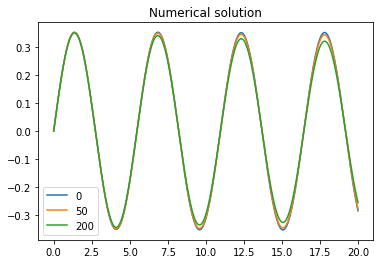

In [151]:
#Oppgave 2f)
def test_multiple_friction_coefficients():
    t0 = 0
    tend = 20
    w0 = np.array([0, 0, 0, 0, 0, 0.4, 0, 0])
    h = 0.001
    t_num1, w_num1 = solve_ode(full_f(0, 0, 0, 0, h), t0, tend, w0, h, method=runge_kutta_4)
    t_num2, w_num2 = solve_ode(full_f(0, 50, 0, 0, h), t0, tend, w0, h, method=runge_kutta_4)
    t_num3, w_num3 = solve_ode(full_f(0, 200, 0, 0, h), t0, tend, w0, h, method=runge_kutta_4)
    plt.title("Numerical solution")
    plt.plot(t_num1, w_num1[:, 4])
    plt.plot(t_num2, w_num2[:, 4])
    plt.plot(t_num3, w_num3[:, 4])
    plt.legend(["0", "50", "200"])
    plt.show()

test_multiple_friction_coefficients()

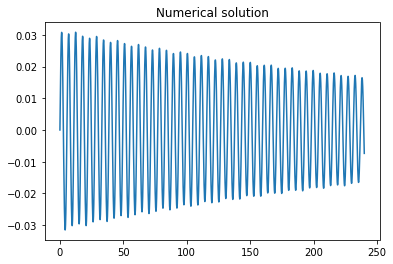

In [152]:
#Oppgave 2g)
def plot_effect_of_harmonic_occilation():
    t0 = 0
    tend = 240
    w0 = np.array([0, 0, 0, 0, 0, 2 * np.pi / 180, 0, 0])
    h = 0.01
    t_num, w_num = solve_ode(full_f(0, 100, 0.625, 0.93 * omega_0, h), t0, tend, w0, h, method=runge_kutta_4)
    plt.title("Numerical solution")
    plt.plot(t_num, w_num[:, 4])

    plt.show()

plot_effect_of_harmonic_occilation()